<a href="https://colab.research.google.com/github/amkayhani/DSML24/blob/main/2_3_Object_Detection_CNN_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with a CNN (From Scratch)

This notebook follows the same step-by-step teaching structure as the regression example, but for **object detection**.

✅ **No transfer learning** (no pre-trained weights). We train a CNN detector from scratch.

## Introduction to Object Detection (CNN-based, From Scratch)

Object Detection answers two questions:

1. **What** is the object? (classification)
2. **Where** is it? (localization using a bounding box)

In this teaching notebook, we start with a **simple detection setting**:
- each image contains **one object**
- we detect its **class** and its **bounding box**

This is a standard first step before multi-object detectors (YOLO/SSD/Faster R-CNN).

### Bounding box representation

We represent a bounding box using the corner format:

$$
b = (x_{min}, y_{min}, x_{max}, y_{max})
$$

To make learning stable, we **normalize** these values by the image width/height so they fall in $[0, 1]$.

### Model output (two-head detector)

Our CNN produces:
- a **class prediction** (softmax over classes)
- a **bounding box prediction** (4 numbers)

### Loss function

We train using a combined loss:

$$
\mathcal{L} = \mathcal{L}_{cls} + \lambda \mathcal{L}_{box}
$$

Where:
- $\mathcal{L}_{cls}$ is categorical cross-entropy
- $\mathcal{L}_{box}$ is a regression loss (Smooth L1 / Huber)
- $\lambda$ controls the balance (we start with $\lambda = 1$)

### Evaluation metrics

- **Classification accuracy**
- **IoU (Intersection over Union)** for bounding box quality:

$$
IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

### Pipeline steps

1. Setup
2. Create a detection dataset
3. Preprocess + train/val/test split
4. Build a CNN detector from scratch
5. Train
6. Evaluate (Accuracy + IoU)
7. Predict and visualise bounding boxes

## 1) Setup (imports + GPU check)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices('GPU')))

TensorFlow: 2.19.0
GPU available: False


## 2) Build a small object detection dataset

To make training fast and easy for students, we create a **synthetic detection dataset**:
- take MNIST digits (28×28)
- paste them randomly onto a larger blank canvas (e.g., 96×96)
- labels:
  - digit class (0–9)
  - bounding box coordinates (xmin, ymin, xmax, ymax)

This is real object detection (localization + classification), but lightweight.


In [ ]:
# Load MNIST (built-in)
(x_train_m, y_train_m), (x_test_m, y_test_m) = keras.datasets.mnist.load_data()

# Normalize MNIST to [0,1]
x_train_m = x_train_m.astype("float32") / 255.0
x_test_m  = x_test_m.astype("float32") / 255.0

print("MNIST train:", x_train_m.shape, y_train_m.shape)
print("MNIST test :", x_test_m.shape, y_test_m.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST train: (60000, 28, 28) (60000,)
MNIST test : (10000, 28, 28) (10000,)


In [ ]:
IMG_SIZE = 96  # canvas size
DIGIT_SIZE = 28

def make_detection_dataset(x_digits, y_digits, n_samples, seed=42):
    rng = np.random.default_rng(seed)
    images = np.zeros((n_samples, IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
    classes = np.zeros((n_samples,), dtype=np.int32)
    bboxes  = np.zeros((n_samples, 4), dtype=np.float32)  # xmin, ymin, xmax, ymax normalized

    for i in range(n_samples):
        idx = rng.integers(0, len(x_digits))
        digit = x_digits[idx]
        cls = y_digits[idx]

        x0 = rng.integers(0, IMG_SIZE - DIGIT_SIZE)
        y0 = rng.integers(0, IMG_SIZE - DIGIT_SIZE)

        canvas = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
        canvas[y0:y0+DIGIT_SIZE, x0:x0+DIGIT_SIZE] = digit

        images[i, :, :, 0] = canvas
        classes[i] = cls

        xmin = x0 / IMG_SIZE
        ymin = y0 / IMG_SIZE
        xmax = (x0 + DIGIT_SIZE) / IMG_SIZE
        ymax = (y0 + DIGIT_SIZE) / IMG_SIZE
        bboxes[i] = [xmin, ymin, xmax, ymax]

    return images, classes, bboxes

# Create train/val/test splits
x_det_train, y_cls_train, y_box_train = make_detection_dataset(x_train_m, y_train_m, n_samples=12000, seed=1)
x_det_val,   y_cls_val,   y_box_val   = make_detection_dataset(x_train_m, y_train_m, n_samples=2000,  seed=2)
x_det_test,  y_cls_test,  y_box_test  = make_detection_dataset(x_test_m,  y_test_m,  n_samples=2000,  seed=3)

print("Detection train:", x_det_train.shape)
print("Detection val  :", x_det_val.shape)
print("Detection test :", x_det_test.shape)

Detection train: (12000, 96, 96, 1)
Detection val  : (2000, 96, 96, 1)
Detection test : (2000, 96, 96, 1)


## 3) Inspect the dataset (images + ground-truth boxes)

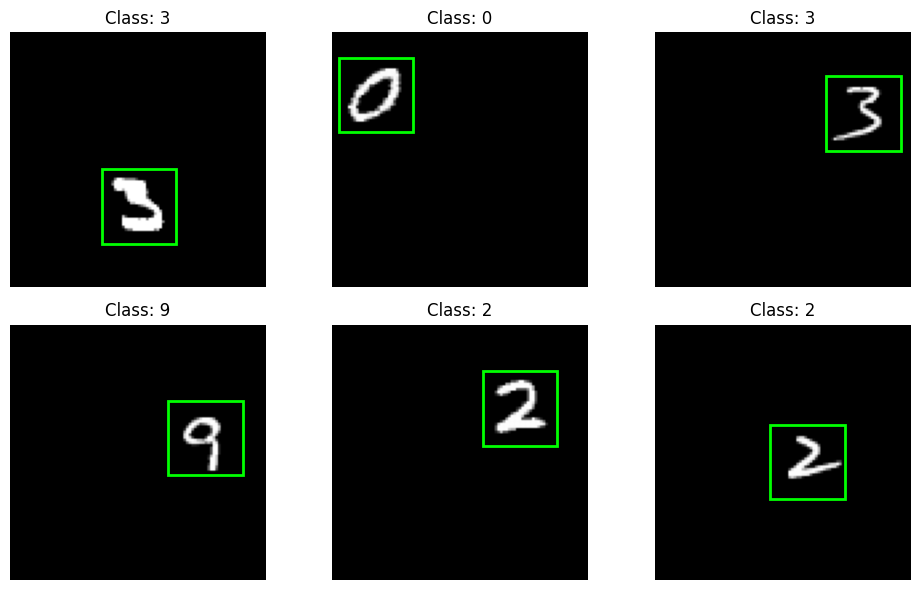

In [ ]:
def draw_bbox(ax, bbox, color="lime", lw=2):
    xmin, ymin, xmax, ymax = bbox
    x0 = xmin * IMG_SIZE
    y0 = ymin * IMG_SIZE
    w = (xmax - xmin) * IMG_SIZE
    h = (ymax - ymin) * IMG_SIZE
    rect = plt.Rectangle((x0, y0), w, h, fill=False, edgecolor=color, linewidth=lw)
    ax.add_patch(rect)

plt.figure(figsize=(10,6))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.imshow(x_det_train[i].squeeze(), cmap="gray")
    draw_bbox(ax, y_box_train[i])
    ax.set_title(f"Class: {y_cls_train[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## 4) Preprocessing

- Images are already normalized to [0,1]
- Bounding boxes are normalized to [0,1]
- Classes are integers 0–9 (we will one-hot encode them)


In [ ]:
NUM_CLASSES = 10

y_cls_train_oh = keras.utils.to_categorical(y_cls_train, NUM_CLASSES)
y_cls_val_oh   = keras.utils.to_categorical(y_cls_val,   NUM_CLASSES)
y_cls_test_oh  = keras.utils.to_categorical(y_cls_test,  NUM_CLASSES)

print("One-hot class shape:", y_cls_train_oh.shape)
print("BBox shape:", y_box_train.shape)

One-hot class shape: (12000, 10)
BBox shape: (12000, 4)


## 5) Build a CNN detector (from scratch)

We use a CNN backbone and **two output heads**:
- classification head (softmax)
- bounding box head (sigmoid to keep outputs in [0,1])


In [ ]:
def build_cnn_detector(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation="relu")(x)

    cls_out = layers.Dense(num_classes, activation="softmax", name="class_out")(x)
    box_out = layers.Dense(4, activation="sigmoid", name="box_out")(x)

    return keras.Model(inputs, outputs=[cls_out, box_out], name="cnn_detector")

model = build_cnn_detector()
model.summary()

Model: "cnn_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_out (Dense)   │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ box_out (Dense)     │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 115,470 (451.05 KB)

 Trainable params: 115,470 (451.05 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Define IoU metric for bounding boxes

In [ ]:
import tensorflow as tf

def iou_metric(y_true, y_pred):
    xA = tf.maximum(y_true[:, 0], y_pred[:, 0])
    yA = tf.maximum(y_true[:, 1], y_pred[:, 1])
    xB = tf.minimum(y_true[:, 2], y_pred[:, 2])
    yB = tf.minimum(y_true[:, 3], y_pred[:, 3])

    inter_w = tf.maximum(0.0, xB - xA)
    inter_h = tf.maximum(0.0, yB - yA)
    inter_area = inter_w * inter_h

    true_area = tf.maximum(0.0, y_true[:, 2] - y_true[:, 0]) * tf.maximum(0.0, y_true[:, 3] - y_true[:, 1])
    pred_area = tf.maximum(0.0, y_pred[:, 2] - y_pred[:, 0]) * tf.maximum(0.0, y_pred[:, 3] - y_pred[:, 1])

    union_area = true_area + pred_area - inter_area + 1e-7
    iou = inter_area / union_area
    return tf.reduce_mean(iou)

## 7) Train the model

We compile with two losses:
- classification: categorical cross-entropy
- bounding box: Huber loss (Smooth L1)

Metrics:
- classification accuracy
- IoU for bounding boxes


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "class_out": "categorical_crossentropy",
        "box_out": keras.losses.Huber()
    },
    metrics={
        "class_out": ["accuracy"],
        "box_out": [iou_metric]
    }
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history = model.fit(
    x_det_train,
    {"class_out": y_cls_train_oh, "box_out": y_box_train},
    validation_data=(x_det_val, {"class_out": y_cls_val_oh, "box_out": y_box_val}),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 652ms/step - box_out_iou_metric: 0.0580 - box_out_loss: 0.0266 - class_out_accuracy: 0.1996 - class_out_loss: 2.1086 - loss: 2.1352 - val_box_out_iou_metric: 0.1001 - val_box_out_loss: 0.0235 - val_class_out_accuracy: 0.4860 - val_class_out_loss: 1.1741 - val_loss: 1.1996 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 122s 647ms/step - box_out_iou_metric: 0.1038 - box_out_loss: 0.0225 - class_out_accuracy: 0.6868 - class_out_loss: 0.9098 - loss: 0.9323 - val_box_out_iou_metric: 0.1305 - val_box_out_loss: 0.0225 - val_class_out_accuracy: 0.8540 - val_class_out_loss: 0.4740 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 146s 670ms/step - box_out_iou_metric: 0.1079 - box_out_loss: 0.0211 - class_out_accuracy: 0.8527 - class_out_loss: 0.4760 - loss: 0.4971 - val_box_out_iou_metric: 0.0931 - val_box_out_loss: 0.0212 - val_class_out_accuracy: 0.9005 - val_class_out_loss: 0.3289 - val_loss: 0.349

## 8) Plot learning curves

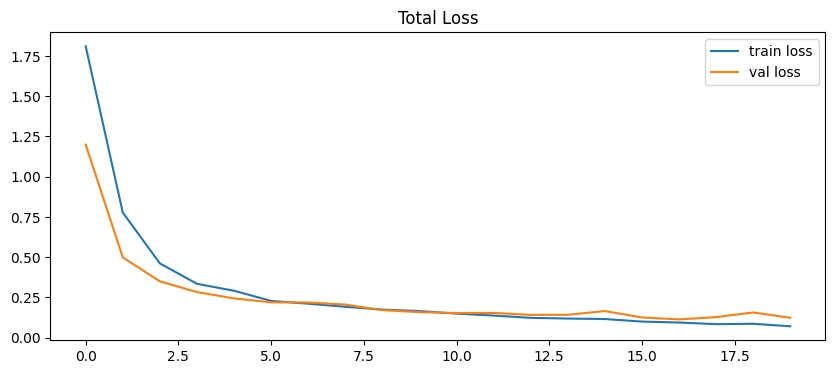

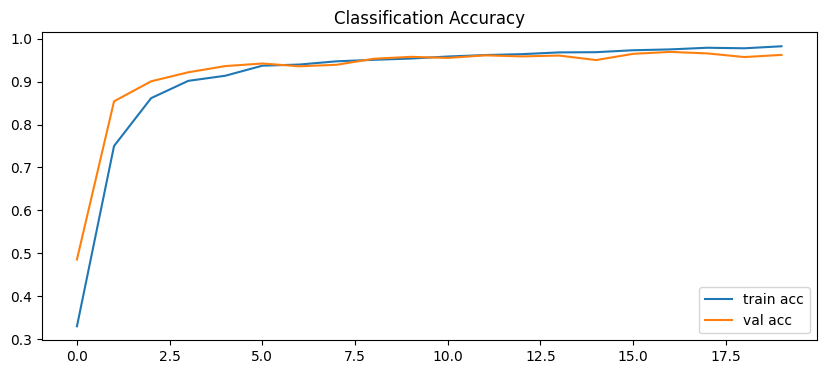

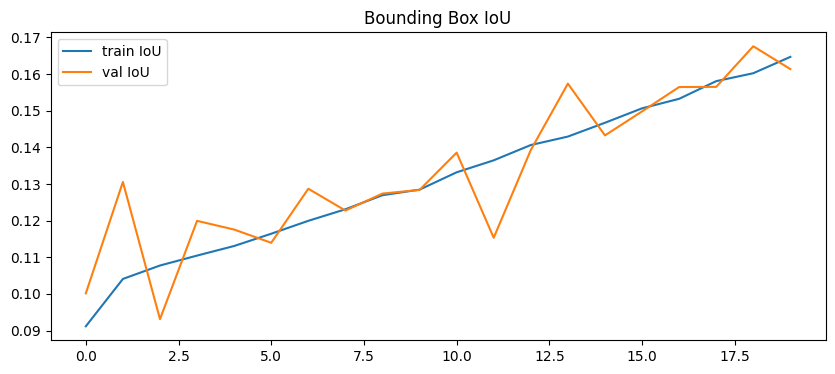

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Total Loss")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["class_out_accuracy"], label="train acc")
plt.plot(history.history["val_class_out_accuracy"], label="val acc")
plt.legend()
plt.title("Classification Accuracy")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["box_out_iou_metric"], label="train IoU")
plt.plot(history.history["val_box_out_iou_metric"], label="val IoU")
plt.legend()
plt.title("Bounding Box IoU")
plt.show()

## 9) Evaluate on the test set

In [ ]:
test_metrics = model.evaluate(
    x_det_test,
    {"class_out": y_cls_test_oh, "box_out": y_box_test},
    verbose=0
)
for name, val in zip(model.metrics_names, test_metrics):
    print(f"{name}: {val:.4f}")

loss: 0.1126
compile_metrics: 0.0974
class_out_loss: 0.0146
box_out_loss: 0.1601


## 10) Predict and visualise bounding boxes

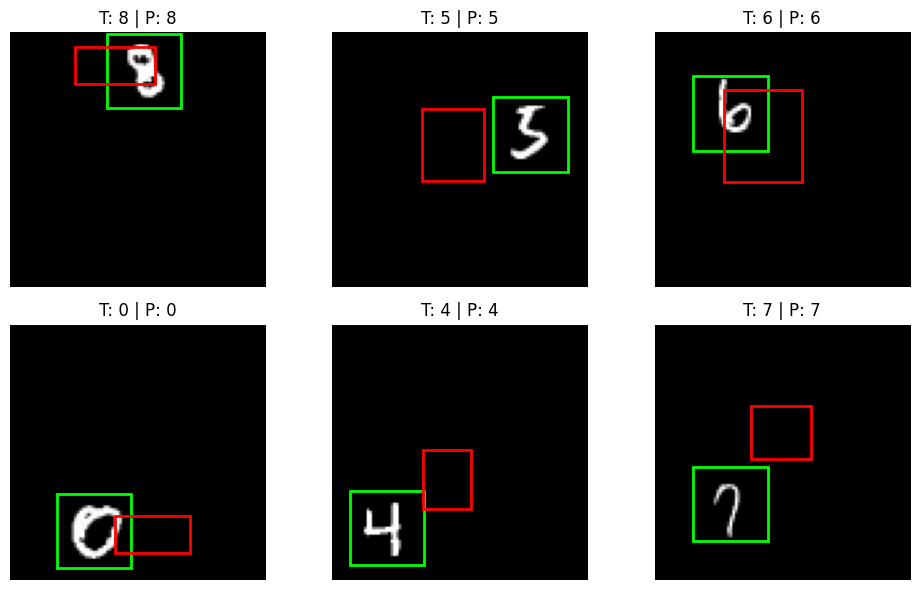

Green = ground truth, Red = prediction


In [ ]:
# Predict on a few test images
idxs = np.random.choice(len(x_det_test), size=6, replace=False)
x_sample = x_det_test[idxs]
true_cls = y_cls_test[idxs]
true_box = y_box_test[idxs]

pred_cls_prob, pred_box = model.predict(x_sample, verbose=0)
pred_cls = np.argmax(pred_cls_prob, axis=1)

plt.figure(figsize=(10,6))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.imshow(x_sample[i].squeeze(), cmap="gray")

    draw_bbox(ax, true_box[i], color="lime", lw=2)   # ground truth
    draw_bbox(ax, pred_box[i], color="red", lw=2)    # prediction

    ax.set_title(f"T: {true_cls[i]} | P: {pred_cls[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

print("Green = ground truth, Red = prediction")

## Exercises (Homework)

1. **Improve the CNN**
   - Add another Conv layer (e.g., 256 filters) and train again.
   - Does IoU improve?

2. **Loss balancing**
   - Add loss weights: `loss_weights={"class_out":1.0, "box_out":2.0}`
   - Does it improve localization?

3. **Harder dataset (advanced)**
   - Place **two digits** per image.
   - What changes would you need in the model output and labels?
